# Using pypardiso sparse direct solver with PyFVTool


## Install pypardiso

[`pypardiso`](https://github.com/haasad/PyPardisoProject) is a simple Python interface to the [Intel MKL PARDISO solver](https://www.intel.com/content/www/us/en/docs/onemkl/developer-reference-c/2023-2/onemkl-pardiso-parallel-direct-sparse-solver-iface.html)

Using `miniconda`/`mambaforge` with exclusively the Conda-forge repositories, `pypardiso` is readily installed (tested only on Windows 10).

```
mamba install pypardiso
```


## Test drive pypardiso

Using the example from the pypardiso README. This example is not ideal, because of the random numbers, which do not play well with the present testing infrastructure.

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pypardiso

In [2]:
pypardiso.__version__

'0.4.2'

In [3]:
A = sp.rand(10, 10, density=0.5, format='csr')

In [4]:
A

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in Compressed Sparse Row format>

In [5]:
b = np.random.rand(10)

In [6]:
x = pypardiso.spsolve(A, b)

In [7]:
# do not output result
# x

## PyFVTool finite-volume (from cylindrical2D_convection notebook)

In [8]:
# enable access to parent directory in order to access pyfvtool module (without pip installation)
from sys import path
path.append('..')

from time import time
import pyfvtool as pf

#### Utility functions

In [9]:
# visualization routine (imshow-based)
def phi_visualize():
    print(f't = {t:.1f} s')
    # avoid ghost cells
    plt.imshow(phi.internalCells(), origin = 'lower',
               extent = [zz[0], zz[-1], rr[0]*rzoom, rr[-1]*rzoom])

In [10]:
# calculate simple finite-volume integral over r
def integral_dr(phi0):
    v = pf.cellVolume(phi0.domain).internalCells()
    c = phi0.internalCells()
    return (v*c).sum(axis=0)

#### FVM settings

In [11]:
Lr = 7.5e-05 # [m] radius of cylinder
Lz = 0.3 # [m] length of cylinder
umax = 2*9.4314e-3 # [m s^-1] max flow velocity = 2 time average flow velocity

In [12]:
# regular grid parameters
Nr = 40
Nz = 500

In [13]:
# initial condition parameters (cell indices)
loadix0 = 20
loadix1 = 40

In [14]:
# timestep parameters
deltat = 0.01 # [s] per time step

In [15]:
# visualization parameters
rzoom = 1000

In [16]:
# SOLVER
# solveur = sp.linalg.spsolve 
solveur = pypardiso.spsolve

#### 2D cylindrical mesh

In [17]:
msh = pf.createMeshCylindrical2D(Nr, Nz, Lr, Lz)

#### Set up Poiseuille flow velocity field

In [18]:
rr = msh.cellcenters.x
zz = msh.facecenters.y

In [19]:
uu =  umax*(1 - (rr**2)/(Lr**2)) # does not depend on zz

In [20]:
u =  pf.createFaceVariable(msh, 1.0)

In [21]:
u.xvalue[:] = 0
u.yvalue[:] = uu[:, np.newaxis]

#### Solution variable

In [22]:
bc = pf.createBC(msh)

In [23]:
phi = pf.createCellVariable(msh, 0.0 , bc)

#### Initial condition

In [24]:
t=0.

In [25]:
# initial condition
for i in range(loadix0, loadix1):
    phi.value[:, i] = 1.0

t = 0.0 s


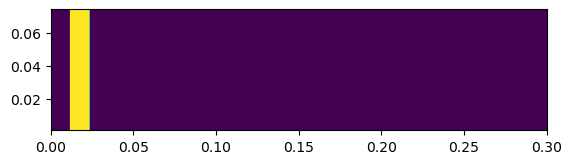

In [26]:
phi_visualize()

In [27]:
initInt = pf.domainInt(phi)
print(initInt)

2.1205750411731096e-10


In [28]:
phiprofs = []
phiprofs.append((t, integral_dr(phi)))

#### Terms with constant matrix contributions

In [29]:
# Mconv = pf.convectionTerm(u) # really ugly?
Mconv = pf.convectionUpwindTerm(u) # numerical diffusion

In [30]:
Mbc, RHSbc = pf.boundaryConditionTerm(bc)

### Solve the convection PDE with time-stepping

In [31]:
exect0 = time()

In [32]:
def do_time_steps(Nsteps):
    global t
    for i in range(Nsteps):
        # create time-dependent matrix contributions (transientTerm)
        M_trans, RHS_trans = pf.transientTerm(phi, deltat, 1.0)
        M = M_trans + Mbc + Mconv
        RHS = RHS_trans + RHSbc
        phi_new = pf.solvePDE(msh, M, RHS,
                              externalsolver = solveur)
        phi.update_value(phi_new)
        t += deltat

In [33]:
do_time_steps(200)
phiprofs.append((t, integral_dr(phi)))

TypeError: PyPardiso requires matrix A to be in CSR or CSC format, but matrix A is: <class 'scipy.sparse._csr.csr_array'>

In [ ]:
print(t, initInt, pf.domainInt(phi))

In [ ]:
phi_visualize()

In [ ]:
do_time_steps(300)
phiprofs.append((t, integral_dr(phi)))

In [ ]:
do_time_steps(500)
phiprofs.append((t, integral_dr(phi)))

In [ ]:
print(t, initInt, pf.domainInt(phi))

In [ ]:
phi_visualize()

In [ ]:
for ix, (tprof, phiprof) in enumerate(phiprofs):
    if ix == 2:
        lbl1 = 'FVM'
    else:
        lbl1 = None
    plt.plot(phi.domain.cellcenters.y, phiprof, 
             label=lbl1)
plt.xlabel('z / m')
plt.legend();

In [ ]:
exect1 = time()

In [ ]:
print('Elapsed time ', exect1 - exect0)